In [15]:
# %matplotlib inline
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
from collections import OrderedDict
import json
import torchvision.transforms as transforms



## Function to transform images

In [16]:
def image_preprocess(image_path=None):
    image = Image.open(image_path)
    normalize = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = normalize(image).unsqueeze(0)
    return image

## Bringing values in image to valid ranges for plotting

In [17]:
def adjust(inp):
    if torch.is_tensor(inp):
        inp=inp.numpy()
    inp = (inp-np.min(inp))/(np.max(inp)-np.min(inp))
    inp*=255
    inp= inp.astype(int)
    return inp

## loading pretrained model

In [18]:
alexnet = models.alexnet(pretrained = True)

## labels.json contains labels of each class

In [19]:
with open('labels.json', 'r') as f:
    labels = json.load(f)

## loading a street sign image and predicting using the model

tensor([919]) tensor([24.0537]) street sign


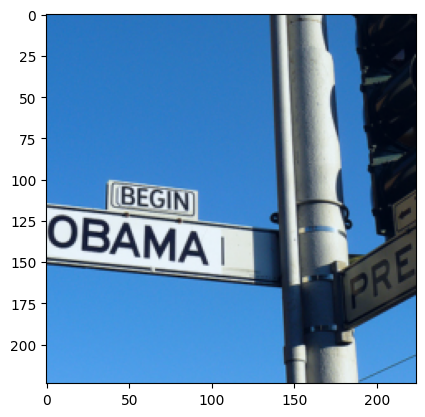

In [20]:
input_tensor = image_preprocess('images/2.jpeg')
plt.imshow(adjust(np.transpose(input_tensor[0], (1,2,0))))

with torch.no_grad():
    output = alexnet(input_tensor)

predicted = reversed(np.argsort(output.data[0])[-1:])

print(predicted, output[0][predicted], labels[str(predicted[0].item())])

## loading a balloon image and predicting using the model

tensor([417]) tensor([36.8993]) balloon


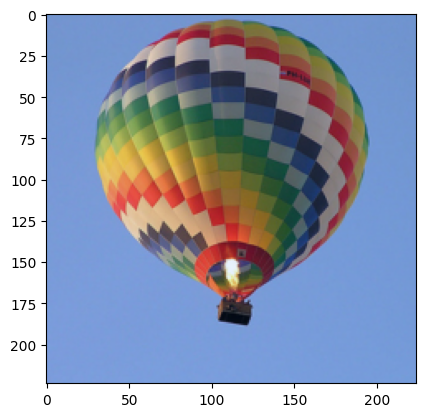

In [21]:
input_tensor3 = image_preprocess('images/30.jpeg')
plt.imshow(adjust(np.transpose(input_tensor3[0], (1,2,0))))

with torch.no_grad():
    output = alexnet(input_tensor3)

predicted = reversed(np.argsort(output.data[0])[-1:])

print(predicted, output[0][predicted], labels[str(predicted[0].item())])

## sample image of the target class used for both the previous images

tensor([258]) tensor([25.7955]) Samoyed, Samoyede


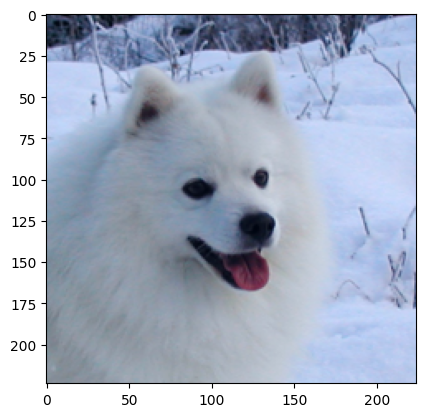

In [22]:
input_tensor2 = image_preprocess('images/29.jpeg')
plt.imshow(adjust(np.transpose(input_tensor2[0], (1,2,0))))

with torch.no_grad():
    output = alexnet(input_tensor2)

predicted = reversed(np.argsort(output.data[0])[-1:])

print(predicted, output[0][predicted], labels[str(predicted[0].item())])

## ADVERSARIAL ATTACK
The adversarial attack is performed using Fast Gradient Sign Method(FGSM)

cross-entropy loss is used to calculate the difference between the model's output and the target class

In each iteration we calculate the gradient of the loss with respect to the input image and update the modiffied image.

using M' = M - r*sign(gradient) where r is step_size, M is the initial image, M' is the modified image

In [23]:
#867

#258
image_tensor = input_tensor
target_class = 258
loss_against = np.asarray([[0.0]*1000])
loss_against[0][258] = 100
loss_against = torch.tensor(loss_against)
loss_fn = torch.nn.CrossEntropyLoss()

max_iterations = 1000
step_size = 0.01
for i in range(max_iterations):
    image_tensor.requires_grad = True
    output = alexnet(image_tensor)
    loss = loss_fn(output, loss_against)
    alexnet.zero_grad()
    loss.backward()
    change = step_size * image_tensor.grad.sign()
    modiff_image = image_tensor - change
    modiff_output = alexnet(modiff_image)
    pred_class = reversed(np.argsort(output.data[0])[-1:])
    if output[0][pred_class] > 20 and pred_class == target_class:
        break
    else:
        image_tensor = modiff_image.detach()  

output = alexnet(modiff_image)

predicted = reversed(np.argsort(output.data[0])[-1:])

print(predicted, output[0][predicted], labels[str(predicted[0].item())])
p1 = modiff_image

tensor([258]) tensor([16.3644], grad_fn=<IndexBackward0>) Samoyed, Samoyede


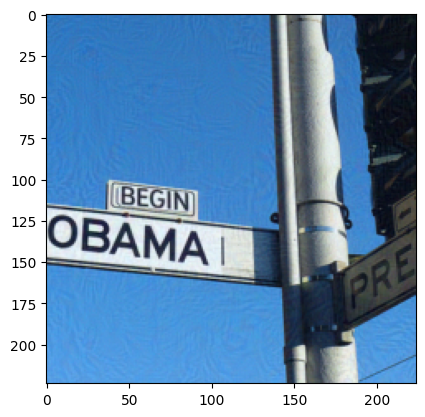

In [24]:
plt.imshow(adjust(np.transpose(p1.detach()[0], (1,2,0))))

In [25]:
#867

#258
image_tensor = input_tensor3
target_class = 258
loss_against = np.asarray([[0.0]*1000])
loss_against[0][258] = 100
loss_against = torch.tensor(loss_against)
loss_fn = torch.nn.CrossEntropyLoss()

max_iterations = 1000
step_size = 0.01
for i in range(max_iterations):
    image_tensor.requires_grad = True
    output = alexnet(image_tensor)
    loss = loss_fn(output, loss_against)
    alexnet.zero_grad()
    loss.backward()
    change = step_size * image_tensor.grad.sign()
    modiff_image = image_tensor - change
    modiff_output = alexnet(modiff_image)
    pred_class = reversed(np.argsort(output.data[0])[-1:])
    if output[0][pred_class] > 20 and pred_class == target_class:
        break
    else:
        image_tensor = modiff_image.detach()  

output = alexnet(modiff_image)

predicted = reversed(np.argsort(output.data[0])[-1:])

print(predicted, output[0][predicted], labels[str(predicted[0].item())])
p2 = modiff_image

tensor([258]) tensor([16.0945], grad_fn=<IndexBackward0>) Samoyed, Samoyede


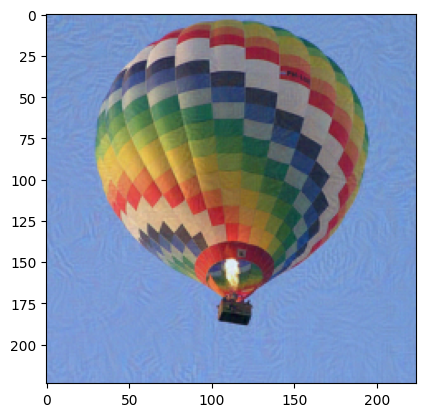

In [26]:
plt.imshow(adjust(np.transpose(p2.detach()[0], (1,2,0))))

## saving the attacked images in .npy files

In [27]:
np.save('modiff_1.npy', np.transpose(p1.detach()[0], (1,2,0)).numpy())
np.save('modiff_2.npy', np.transpose(p2.detach()[0], (1,2,0)).numpy())